# Estancias Point Analysis

Use logistic regression to see how vegetation and terrain indices can be used to discriminate between true and false estancias locations

## Load in GeoPacha Data

Load in the coordinates of the Estancias and the survey polygon.

In [1]:
import geopandas as gpd

estancias = gpd.read_file("Estancias_corrals_from_sat_imagery")
estancias_crs = estancias.crs
estancias = estancias[['fid','locus_type','lat','lon']].dropna().reset_index().drop(columns = 'index')
estancias

,fid,locus_type,lat,lon
0,4.0,6.0,-16.910967,-70.644626
1,5.0,6.0,-17.040630,-69.742321
2,6.0,13.0,-17.310982,-69.975398
3,7.0,13.0,-15.070609,-73.132203
4,8.0,13.0,-15.070327,-73.116103
...,...,...,...,...
9535,9539.0,6.0,-16.095296,-70.985209
9536,9540.0,6.0,-16.096054,-70.974107
9537,9541.0,6.0,-15.147478,-73.133663
9538,9542.0,6.0,-15.229275,-73.143675


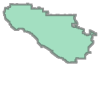

In [2]:
survey_polygon = gpd.read_file("Southwest_survey_polygon.shp", SHAPE_RESTORE_SHX = True)
survey_polygon = survey_polygon['geometry'].iloc[0]
survey_polygon

In [3]:
survey_polygon.area * (111**2)

80658.19440000052

Note that both the polygon and estancias coordinates are both conveniently already in WGS 84

# Generate Negative Samples

In [4]:
percent_negative = 0.5
n_positive = len(estancias)
n_negative = int((percent_negative*n_positive) / (1-percent_negative))
n_negative

9540

In [5]:
from shapely.geometry import Point
import random

def uniform_points(poly, n):
    lons = []; lats = []
    bbox = poly.bounds
    tries = 0
    while(len(lons) < n):
        lon = random.uniform(bbox[0], bbox[2])
        lat = random.uniform(bbox[1], bbox[3])
        if poly.contains(Point(lon,lat)):
            lons.append(lon)
            lats.append(lat)
        tries += 1
    print(tries)
    return(lons,lats)

In [6]:
import pandas as pd

positive_samples = pd.DataFrame({"lat":estancias["lat"],"lon":estancias["lon"]}).copy()
positive_samples["label"] = 1

#generate n_negative sample longitude,latitudes within the survey polygon
negative_lon, negative_lat = uniform_points(survey_polygon, n_negative)
negative_samples = pd.DataFrame({"lat":negative_lat,"lon":negative_lon})
negative_samples["label"] = 0

samples = pd.concat([positive_samples,negative_samples],axis=0,ignore_index = True)

19016


In [7]:
samples

,lat,lon,label
0,-16.910967,-70.644626,1
1,-17.040630,-69.742321,1
2,-17.310982,-69.975398,1
3,-15.070609,-73.132203,1
4,-15.070327,-73.116103,1
...,...,...,...
19075,-15.458045,-72.074931,0
19076,-15.783497,-70.045505,0
19077,-15.729784,-71.965951,0
19078,-16.996939,-71.003280,0


In [8]:
import matplotlib.pyplot as plt

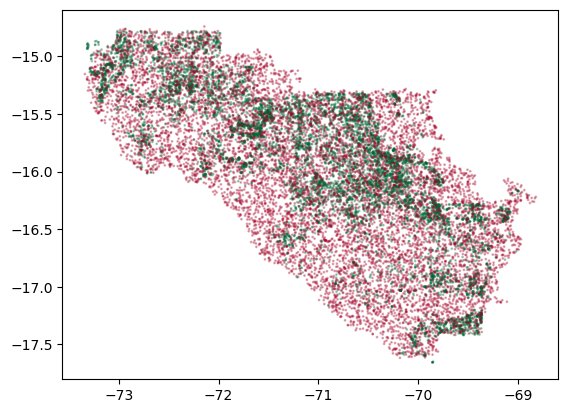

In [9]:
plt.scatter(samples["lon"], samples["lat"], s = 1, alpha = 0.3,c = samples["label"], cmap = "RdYlGn")

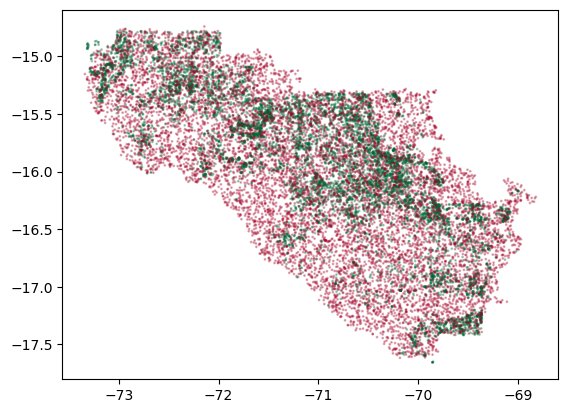

In [10]:
plt.scatter(samples["lon"], samples["lat"], s = 1, alpha = 0.3,c = samples["label"], cmap = "RdYlGn")

# Attach Vegetation Data

We will use the MODIS dataset to add 16-day average NDVI data

In [17]:
import hs_geofuncs as hsg
import numpy as np

In [12]:
import importlib
importlib.reload(hsg)

<module 'hs_geofuncs' from '/home/jovyan/estancias/hs_geofuncs.py'>

In [13]:
years = ["2018","2019","2020"]
months = ["01","02","03","04","05","06","07","08","09","10","11","12"]
for year in years:
    for month in months:
        print("Evaluating vegetation indices in the time range "+year+"-"+month)
        samples = hsg.add_data(samples, 
                       ["ndvi-"+year+"-"+month,"evi-"+year+"-"+month],
                       collection = "modis-13Q1-061",
                       bands = ["250m_16_days_NDVI","250m_16_days_EVI"],
                       time_range = year+"-"+month,
                       crs = estancias_crs,
                       odc_args = {"crs":"EPSG:3857",
                                "resolution":250},
                       shapely_in_bds = True,
                       verbose = 1)
        

Evaluating vegetation indices in the time range 2018-01
Sampling completed in 65.37898683547974 seconds
Evaluating vegetation indices in the time range 2018-02
Sampling completed in 61.74362826347351 seconds
Evaluating vegetation indices in the time range 2018-03
Sampling completed in 62.48150110244751 seconds
Evaluating vegetation indices in the time range 2018-04
Sampling completed in 61.74660897254944 seconds
Evaluating vegetation indices in the time range 2018-05
Sampling completed in 62.74929141998291 seconds
Evaluating vegetation indices in the time range 2018-06
Sampling completed in 61.87073874473572 seconds
Evaluating vegetation indices in the time range 2018-07
Sampling completed in 61.11169624328613 seconds
Evaluating vegetation indices in the time range 2018-08
Sampling completed in 62.81536293029785 seconds
Evaluating vegetation indices in the time range 2018-09
Sampling completed in 60.936399936676025 seconds
Evaluating vegetation indices in the time range 2018-10
Samplin

In [14]:
yms = [year + "-" + month for year in years for month in months]
positives = samples[samples["label"]==1]
negatives = samples[samples["label"]==0]
positive_average_ndvis = [positives['ndvi-'+ym].mean() for ym in yms]
negative_average_ndvis = [negatives['ndvi-'+ym].mean() for ym in yms]
positive_average_evis = [positives['evi-'+ym].mean() for ym in yms]
negative_average_evis = [negatives['evi-'+ym].mean() for ym in yms]

In [18]:
pndvi = []
nndvi = []
for month in months:
    pndvi.append(np.mean([positives['ndvi-'+year+'-'+month].mean() for year in years]))
    nndvi.append(np.mean([negatives['ndvi-'+year+'-'+month].mean() for year in years]))

Text(0, 0.5, 'emodis NDVI')

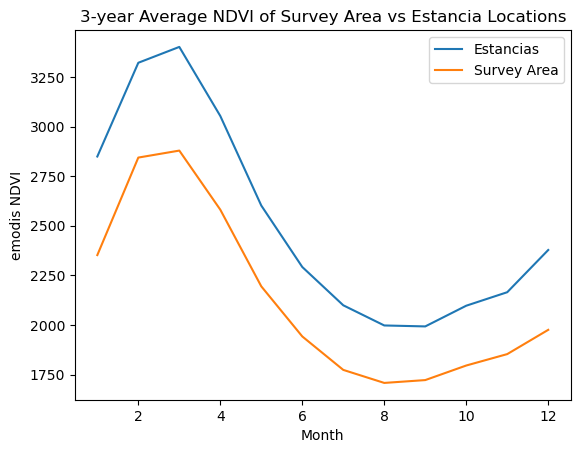

In [22]:
plt.plot(list(range(1,13)),pndvi, label = "Estancias")
plt.plot(list(range(1,13)),nndvi, label = "Survey Area")
plt.title("3-year Average NDVI of Survey Area vs Estancia Locations")
plt.legend()
plt.xlabel("Month")
plt.ylabel("emodis NDVI")

In [ ]:
plt.plot(list(range(1,len(yms)+1)),positive_average_ndvis, label = "Estancias")
plt.plot(list(range(1,len(yms)+1)),negative_average_ndvis, label = "Survey Area")
plt.title("NDVI of Survey Area vs Estancia Locations")
plt.legend()

In [ ]:
plt.plot(list(range(1,len(yms)+1)),positive_average_evis, label = "estancias")
plt.plot(list(range(1,len(yms)+1)),negative_average_evis, label = "survey_area")
plt.legend()

In [ ]:
ndvi_corrs = [samples['ndvi-'+ym].corr(samples['label']) for ym in yms]
evi_corrs = [samples['evi-'+ym].corr(samples['label']) for ym in yms]

plt.plot(list(range(1,len(yms)+1)),ndvi_corrs, label = "ndvi correlation")
plt.plot(list(range(1,len(yms)+1)),evi_corrs, label = "evi correlation")
plt.legend()

In [ ]:
ndvi_corr = []
evi_corr = []

for month in months:
    ndvi_corr.append(np.mean([samples['ndvi-'+year+'-'+month].corr(samples['label']) for year in years]))
    evi_corr.append(np.mean([samples['evi-'+year+'-'+month].corr(samples['label']) for year in years]))

In [ ]:
plt.plot(list(range(1,13)),ndvi_corr, label = "NDVI")
plt.plot(list(range(1,13)),evi_corr, label = "EVI")
plt.title("3-year Average NDVI of Survey Area vs Estancia Locations")
plt.legend()

In [ ]:
plt.scatter(samples["lon"], samples["lat"], s = 1, alpha = 0.3,c = samples["ndvi-02"], cmap = "RdYlGn")

In [ ]:
print("Average Survey Area NDVI:", negatives["ndvi-02"].mean())
print("Average Estancia NDVI:", positives["ndvi-02"].mean())
print("Correlation between labels and NDVI:", samples["ndvi-02"].corr(samples["label"]))

In [ ]:
plt.scatter(samples["lon"], samples["lat"], s = 1, alpha = 0.3,c = samples["evi"], cmap = "RdYlGn")

In [ ]:
print("Average Survey Area EVI:", positives["evi"].mean())
print("Average Estancia EVI:", negatives["evi"].mean())
print("Correlation between labels and EVI:", samples["evi"].corr(samples["label"]))

In [ ]:
edge_errors = (samples["ndvi"] == -3000)
clean_samples = samples[~edge_errors]
sum(edge_errors)
samples = clean_samples.copy().reset_index().drop(columns = "index")

In [ ]:
plt.scatter(clean_samples["lon"], clean_samples["lat"], s = 1, alpha = 0.3,c = clean_samples["ndvi"], 
            cmap = "RdYlGn", vmin = -3000)

In [ ]:
clean_samples[clean_samples["label"]==0]["ndvi"].mean()

In [ ]:
clean_samples[clean_samples["label"]==1]["ndvi"].mean()

In [ ]:
positives = samples[samples["label"]==1]
negatives = samples[samples["label"]==0]

print("Average Survey Area NDVI:", negatives["ndvi-2019-02"].mean())
print("Average Estancia NDVI:", positives["ndvi-2019-02"].mean())
print("Correlation between labels and NDVI:", samples["ndvi-2019-07"].corr(samples["label"]))

print("Average Survey Area EVI:", positives["evi-2019-02"].mean())
print("Average Estancia EVI:", negatives["evi-2019-02"].mean())
print("Correlation between labels and EVI:", samples["evi-2019-07"].corr(samples["label"]))

# Attach Terrain Data

In [ ]:
import importlib
importlib.reload(hsg)

In [ ]:
samples = hsg.add_data(samples, 
                       ["elevation","aspect","grade"],
                       collection = "cop-dem-glo-30",
                       bands = ["data"],
                       derived_bands = ["aspect","grade"],
                       time_range = None,
                       crs = estancias_crs,
                       shapely_in_bds = True)

In [ ]:
plt.scatter(samples["lon"], samples["lat"], s = 1.5, alpha = 0.5,c = samples["elevation"], cmap = "gray", vmin = 2000, vmax = 5000)

In [ ]:
samples['aspect'] = 360 - (samples['aspect']-90)%360

In [ ]:
positives = samples[samples["label"]==1]
negatives = samples[samples["label"]==0]

print("Average Survey Area Elevation:", negatives["elevation"].mean(), "meters")
print("Average Estancia Elevation:", positives["elevation"].mean(), "meters")
print("Correlation between labels and Elevation:", samples["elevation"].corr(samples["label"]))

In [ ]:
plt.hist(positives['elevation'], alpha = 0.5,density = True, label = "Estancias", bins = 20)
plt.hist(negatives['elevation'], alpha = 0.5,density = True, label = "Survey Area", bins = 20)
plt.title("Density of Estancia Elevations vs Survey Area")
plt.xlabel("Elevation (Meters)")
plt.legend()

In [ ]:
import numpy as np

samples['eastness'] = np.cos(np.radians(samples['aspect']))
samples['northness'] = np.sin(np.radians(samples['aspect']))

In [ ]:
plt.scatter(samples["lon"], samples["lat"], s = 1.5, alpha = 0.5,
            c = samples["northness"], cmap = "gray")

In [ ]:
samples[samples['aspect']==-1]

In [ ]:
samples[samples['northness']<-0.98]

In [ ]:
samples['eastness']**2 + samples['northness']**2

In [ ]:
#aspect of -1 means flat, usually indicates a position on a body of water
positives = samples[samples["label"]==1 & (samples['aspect'] != -1)]
negatives = samples[samples["label"]==0 & (samples['aspect'] != -1)]

print("Average Survey Area Northness", negatives["northness"].mean(), "meters")
print("Average Estancia Northness:", positives["northness"].mean(), "meters")
print("Correlation between labels and Northness:", samples["northness"].corr(samples["label"]))

print("Average Survey Area Eastness", negatives["eastness"].mean(), "meters")
print("Average Estancia Eastness:", positives["eastness"].mean(), "meters")
print("Correlation between labels and Eastness:", samples["eastness"].corr(samples["label"]))

In [ ]:
plt.hist(positives['northness'], alpha = 0.5,density = True, label = "True", bins = 30)
plt.hist(negatives['northness'], alpha = 0.5,density = True, label = "False", bins = 30)
plt.legend()

In [ ]:
plt.hist(positives['eastness'], alpha = 0.5,density = True, label = "True", bins = 30)
plt.hist(negatives['eastness'], alpha = 0.5,density = True, label = "False", bins = 30)
plt.legend()

In [ ]:
max(positives['aspect'])

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
ax.hist(positives['aspect']*np.pi/180, alpha = 0.5,density = True, label = "Estancias", bins = 20)
ax.hist(negatives['aspect']*np.pi/180, alpha = 0.5,density = True, label = "Survey Area", bins = 20)
plt.legend(loc = 'lower right')
ax.set_title("Density of Estancia Aspects")
plt.show()

In [ ]:
plt.scatter(samples["lon"], samples["lat"], s = 1.5, alpha = 0.5,c = samples["grade"],cmap = 'viridis')

In [ ]:
positives = samples[samples["label"]==1 & (samples['aspect'] != -1)]
negatives = samples[samples["label"]==0 & (samples['aspect'] != -1)]

print("Average Survey Area Grade:", negatives["grade"].mean(), "meters")
print("Average Estancia Grade:", positives["grade"].mean(), "meters")
print("Correlation between labels and Grade:", samples["grade"].corr(samples["label"]))

In [ ]:
plt.hist(positives['grade'], alpha = 0.5,density = True, label = "Estancias", bins = 30)
plt.hist(negatives['grade'], alpha = 0.5,density = True, label = "Survey Area", bins = 30)
plt.title("Density of Estancia Grades vs Survey Area")
plt.xlabel("Grade")
plt.legend()

In [ ]:
plt.scatter(samples["ndvi"], samples["elevation"], c = samples["label"], alpha = 0.2)

In [ ]:
plt.hist(positives['elevation'], alpha = 0.5,density = True, label = "True", bins = 20)
plt.hist(negatives['elevation'], alpha = 0.5,density = True, label = "False", bins = 20)
plt.legend()

In [ ]:
plt.hist(positives['grade'], alpha = 0.5,density = True, label = "True", bins = 20)
plt.hist(negatives['grade'], alpha = 0.5,density = True, label = "False", bins = 20)
plt.legend()

In [ ]:
max(samples['aspect'])

In [ ]:
samples

Aspect is degrees clockwise from north of the direction of maximum descent